# Retrieval Effectiveness Testing

In [47]:
import os
import json
import time
import math
import numpy as np
from scipy.spatial.distance import cosine
from dotenv import load_dotenv
import numpy as np
import psycopg2
from psycopg2.extras import Json 
from psycopg2.extras import RealDictCursor
import ast
from typing import List, Tuple, Any
from langchain.schema import BaseRetriever, Document
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.prompts import PromptTemplate
from pydantic import Field
from sklearn.metrics.pairwise import cosine_similarity
from tenacity import retry, stop_after_attempt, wait_random_exponential
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [32]:
## 1. Setup Environment and Configure Connections

# Load environment variables
load_dotenv()

# Setup your chat model

openai_api_key = os.getenv("OPENAI_API_KEY") # Get OpenAI API key from environment variables
#llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, openai_api_key=openai_api_key) # Setup the language model
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, openai_api_key=openai_api_key)

# Setup embeddings
embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key) # Create embeddings object using OpenAI's embedding model

# Get PostgreSQL connection details from environment variables
username = os.getenv('PG_ADMIN_USERNAME')  # Get the server admin login name stored in .env file
password = os.getenv('PG_ADMIN_PASSWORD')  # Get the server password stored in .env file
host = os.getenv('PG_SERVER_NAME')         # Get the server name stored in .env file
port = os.getenv('POSTGRES_PORT')          # Get the Standard PostgreSQL port stored in .env file
database = os.getenv('PG_DATABASE')        # Get the database name stored in .env file

# The PostgreSQL connection string 
POSTGRESQL_CONNECTION = f"postgresql://{username}:{password}@{host}:{port}/{database}"

In [67]:
## 2. Define a Custom Document Retrieval Function (PostgresRetriever)  # Help from chatgpt!
# Vector-based retrieval: This uses vector similarity search using the pgvector extension in PostgreSQL.
 
# Custom Retriever class that extends LangChain's BaseRetriever



class PostgresRetriever(BaseRetriever):
    connection_string: str = Field(...)  # PostgreSQL connection string
    collection_name: str = Field(...)    # Name of the table in the database
    embedding_function: Any = Field(...) # Function to create embeddings

    class Config:
        arbitrary_types_allowed = True  # Allows for custom types in Pydantic

    def _get_relevant_documents(self, query: str) -> List[Document]:
        # Convert the query to a vector embedding
        query_embedding = self.embedding_function.embed_query(query)

        with psycopg2.connect(self.connection_string) as conn:
            with conn.cursor(cursor_factory=RealDictCursor) as cur:
                # Execute SQL query to fetch relevant documents
                # Uses vector similarity search (<->) to find closest matches
                cur.execute(f"""
                    SELECT question_id, question_full, answers, metadata,
                           question_vector <-> %s::vector AS document_distance,
                           answers_vector <-> %s::vector AS answers_distance,
                           question_vector::text as question_vector_text
                    FROM {self.collection_name}
                    ORDER BY question_vector <-> %s::vector
                    LIMIT 20
                """, (json.dumps(query_embedding), json.dumps(query_embedding), json.dumps(query_embedding)))
                results = cur.fetchall()

        all_answers = []
        for result in results:
            metadata = result['metadata']
            answers = result['answers']
            # Convert distances to relevance scores (closer = more relevant)
            document_relevance = 1 - result['document_distance']
            answers_relevance = 1 - result['answers_distance']
            question_vector = json.loads(result['question_vector_text'])

            for answer in answers:
                answer_text = answer['answer']
                source = answer['source']

                # Assign trust score based on source
                if source == 'AskTheraRAGBuddy':
                    trust_score = 0.5
                elif source == 'Mental Health Dataset':
                    trust_score = 0.75
                else:
                    trust_score = 1.0

                # Combine document relevance, answer relevance, and trust score
                combined_score = (
                    document_relevance * 0.4 +  # Document relevance
                    answers_relevance * 0.4 +   # Answer relevance
                    trust_score * 0.2           # Trust score
                )

                all_answers.append({
                    'question_id': result['question_id'],
                    'question_full': result['question_full'],
                    'answer_text': answer_text,
                    'source': source,
                    'score': combined_score,
                    'metadata': metadata,
                    'question_vector': question_vector  # Add this line
                })

        # Sort answers and select top 10
        sorted_answers = sorted(all_answers, key=lambda x: x['score'], reverse=True)[:10]

        # Create Document objects for the top 10 answers
        documents = []
        for answer in sorted_answers:
            doc = Document(
                page_content=f"Question: {answer['question_full']}\nAnswer: {answer['answer_text']}",
                metadata={
                    'question_id': answer['question_id'],
                    'source': answer['source'],
                    'score': answer['score'],
                    'topic': answer['metadata'].get('topic', ''),
                    'question_title': answer['metadata'].get('question_title', ''),
                    'question_vector': answer['question_vector']  # Use this line
                }
            )
            documents.append(doc)

        return documents
        
    async def _aget_relevant_documents(self, query: str) -> List[Document]:
        # Async version of the retrieval method (currently just calls the sync version)
        return self._get_relevant_documents(query)

# Create an instance of the PostgresRetriever class
postgres_retriever = PostgresRetriever(
    connection_string=POSTGRESQL_CONNECTION,  # PostgreSQL connection string
    collection_name="talk",                   # Name of the table storing documents
    embedding_function=embeddings             # Embedding function to generate query vectors
)

####################################################################################################################################################################
# Why we need this custom retriever:
# 1. Direct database access: We interact directly with our PostgreSQL database.
# 2. Use of native vector operations: We use PostgreSQL's built-in vector operations for similarity search.
# 3. Integration with LangChain: By extending BaseRetriever, our custom retriever works with LangChain's tools and chains.
# 4. Customization: We can easily modify the retrieval logic or add filters if needed in the future.

# Evaluation

In [68]:
# Retrieval consistency measures how stable the results are across multiple runs.

def retrieval_consistency(retriever, queries, n_results=5):
    consistency_scores = []
    for query in queries:
        results1 = set(doc.metadata['question_id'] for doc in retriever._get_relevant_documents(query))
        results2 = set(doc.metadata['question_id'] for doc in retriever._get_relevant_documents(query))
        jaccard = len(results1.intersection(results2)) / len(results1.union(results2))
        consistency_scores.append(jaccard)
    return np.mean(consistency_scores)


In [69]:
# Unique documents ratio indicates the diversity of retrieved documents across different queries.

def unique_documents_ratio(retriever, queries, n_results=5):
    all_docs = []
    for query in queries:
        docs = retriever._get_relevant_documents(query)
        all_docs.extend([doc.metadata['question_id'] for doc in docs])
    unique_ratio = len(set(all_docs)) / len(all_docs)
    return unique_ratio


In [70]:
# Query variation test assesses how well the system handles different phrasings of similar queries.

def query_variation_test(retriever, base_query, variations):
    base_results = set(doc.metadata['question_id'] for doc in retriever._get_relevant_documents(base_query))
    variation_scores = []
    for variation in variations:
        var_results = set(doc.metadata['question_id'] for doc in retriever._get_relevant_documents(variation))
        overlap = len(base_results.intersection(var_results)) / len(base_results.union(var_results))
        variation_scores.append(overlap)
    return np.mean(variation_scores)


In [71]:
# Response time gives you a performance benchmark.



# Response time gives you a performance benchmark.
def average_response_time(retriever, queries, n_runs=5):
    times = []
    for _ in range(n_runs):
        for query in queries:
            start_time = time.time()  # Use time.time() to capture start
            retriever._get_relevant_documents(query)
            end_time = time.time()  # Use time.time() to capture end
            times.append(end_time - start_time)
    return np.mean(times), np.std(times)


In [72]:
# Semantic coherence evaluates how semantically related the retrieved documents are to each other.

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def semantic_coherence(retriever, queries):
    """
    Tests semantic coherence of the retrieved documents by measuring the cosine 
    similarity between the document vectors retrieved for each query.
    """
    query_embeddings = [retriever.embedding_function.embed_query(query) for query in queries]
    
    all_retrieved_vectors = []
    for query in queries:
        results = retriever._get_relevant_documents(query)
        doc_vectors = [doc.metadata['question_vector'] for doc in results if 'question_vector' in doc.metadata]
        all_retrieved_vectors.extend(doc_vectors)
    
    # Computing average pairwise cosine similarity
    if len(all_retrieved_vectors) > 1:
        similarities = cosine_similarity(all_retrieved_vectors)
        # Exclude self-similarities (diagonal)
        np.fill_diagonal(similarities, 0)
        return np.mean(similarities)
    else:
        return 0

In [73]:
# Run the tests
test_queries = ["What are symptoms of depression?", "How to deal with anxiety?", "Is therapy effective?"]

consistency = retrieval_consistency(postgres_retriever, test_queries)
print(f"Retrieval Consistency: {consistency:.4f}")

diversity = unique_documents_ratio(postgres_retriever, test_queries)
print(f"Unique Documents Ratio: {diversity:.4f}")

base_query = "What are symptoms of depression?"
variations = [
    "Signs of depression",
    "How do I know if I'm depressed?",
    "Depression indicators",
    "Common depression symptoms"
]
variation_score = query_variation_test(postgres_retriever, base_query, variations)
print(f"Query Variation Score: {variation_score:.4f}")

mean_time, std_time = average_response_time(postgres_retriever, test_queries)
print(f"Average Response Time: {mean_time:.4f}s (±{std_time:.4f}s)")

coherence = semantic_coherence(postgres_retriever, test_queries)
print(f"Semantic Coherence: {coherence:.4f}")

Retrieval Consistency: 1.0000
Unique Documents Ratio: 0.3667
Query Variation Score: 0.5306
Average Response Time: 1.2096s (±0.0721s)
Semantic Coherence: 0.8084


In [74]:
def retrieval_consistency(retriever, queries, n_results=10):
    """
    Tests if the retrieval is consistent by querying the same questions twice 
    and measuring how much the results overlap.
    """
    consistency_scores = []
    for query in queries:
        results1 = set(doc.metadata['question_id'] for doc in retriever._get_relevant_documents(query))
        results2 = set(doc.metadata['question_id'] for doc in retriever._get_relevant_documents(query))
        
        # Calculate the Jaccard similarity between the two result sets
        if results1 or results2:
            jaccard = len(results1.intersection(results2)) / len(results1.union(results2))
        else:
            jaccard = 0
        
        consistency_scores.append(jaccard)
    
    return sum(consistency_scores) / len(consistency_scores)

In [75]:
def unique_documents_ratio(retriever, queries, n_results=10):
    """
    Tests the uniqueness of retrieved documents across different queries 
    by calculating the ratio of unique documents to total retrieved documents.
    """
    all_results = []
    for query in queries:
        results = retriever._get_relevant_documents(query)
        all_results.extend([doc.metadata['question_id'] for doc in results])

    unique_results = set(all_results)
    
    # Calculate the ratio of unique documents
    return len(unique_results) / len(all_results)


In [76]:
def query_variation_test(retriever, base_query, variations, n_results=10):
    """
    Tests the variation handling of the retriever by checking if variations 
    of a query return overlapping documents.
    """
    base_results = set(doc.metadata['question_id'] for doc in retriever._get_relevant_documents(base_query))
    
    variation_scores = []
    for variation in variations:
        variation_results = set(doc.metadata['question_id'] for doc in retriever._get_relevant_documents(variation))
        
        # Calculate the Jaccard similarity between base query and variation query results
        if base_results or variation_results:
            jaccard = len(base_results.intersection(variation_results)) / len(base_results.union(variation_results))
        else:
            jaccard = 0
            
        variation_scores.append(jaccard)
    
    return sum(variation_scores) / len(variation_scores)


In [77]:
import time

def average_response_time(retriever, queries):
    """
    Tests the average response time of the retriever across multiple queries.
    """
    times = []
    for query in queries:
        start_time = time.time()
        retriever._get_relevant_documents(query)
        end_time = time.time()
        
        times.append(end_time - start_time)
    
    mean_time = sum(times) / len(times)
    std_time = (sum((t - mean_time) ** 2 for t in times) / len(times)) ** 0.5
    
    return mean_time, std_time


In [78]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def semantic_coherence(retriever, queries):
    """
    Tests semantic coherence of the retrieved documents by measuring the cosine 
    similarity between the document vectors retrieved for each query.
    """
    query_embeddings = [retriever.embedding_function.embed_query(query) for query in queries]
    
    all_retrieved_vectors = []
    for query in queries:
        results = retriever._get_relevant_documents(query)
        doc_vectors = [doc.metadata['question_vector'] for doc in results]
        all_retrieved_vectors.append(doc_vectors)
    
    # Flattening the list of document vectors and computing average pairwise cosine similarity
    flattened_vectors = [np.array(vector) for vectors in all_retrieved_vectors for vector in vectors]
    if len(flattened_vectors) > 1:
        similarities = cosine_similarity(flattened_vectors)
        return np.mean(similarities)
    else:
        return 0


In [79]:

# Define your test queries
test_queries = ["What are symptoms of depression?", "How to deal with anxiety?", "Is therapy effective?"]

# Test 1: Retrieval Consistency
consistency = retrieval_consistency(postgres_retriever, test_queries)
print(f"Retrieval Consistency: {consistency:.4f}")

# Test 2: Unique Documents Ratio
diversity = unique_documents_ratio(postgres_retriever, test_queries)
print(f"Unique Documents Ratio: {diversity:.4f}")

# Test 3: Query Variation Test
base_query = "What are symptoms of depression?"
variations = [
    "Signs of depression",
    "How do I know if I'm depressed?",
    "Depression indicators",
    "Common depression symptoms"
]
variation_score = query_variation_test(postgres_retriever, base_query, variations)
print(f"Query Variation Score: {variation_score:.4f}")

# Test 4: Average Response Time
mean_time, std_time = average_response_time(postgres_retriever, test_queries)
print(f"Average Response Time: {mean_time:.4f}s (±{std_time:.4f}s)")

# Test 5: Semantic Coherence
coherence = semantic_coherence(postgres_retriever, test_queries)
print(f"Semantic Coherence: {coherence:.4f}")

Retrieval Consistency: 1.0000
Unique Documents Ratio: 0.3667
Query Variation Score: 0.5306
Average Response Time: 1.3408s (±0.0995s)
Semantic Coherence: 0.8417


## More tests

Additional Notes:

- Cosine Similarity Test is a quantitative approach that measures semantic similarity, and it is useful for determining the effectiveness of vector embeddings.
- Precision/Recall Test helps to evaluate retrieval accuracy. It is particularly useful for information retrieval and assessing how well the system retrieves the correct answers.
- LLM-based Judgement Test uses a qualitative evaluation by allowing a large language model (like GPT) to evaluate the generated answers, focusing on contextual correctness.
These tests should provide you with a well-rounded evaluation of the performance of the system, combining both quantitative (cosine similarity, precision/recall) and qualitative (LLM judgement) methods.

In [80]:
# Load environment variables
load_dotenv()

# Setup the chat model
openai_api_key = os.getenv("OPENAI_API_KEY")
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, openai_api_key=openai_api_key)

# Setup embeddings
embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)

# Get PostgreSQL connection details from environment variables
username = os.getenv('PG_ADMIN_USERNAME')
password = os.getenv('PG_ADMIN_PASSWORD')
host = os.getenv('PG_SERVER_NAME')
port = os.getenv('POSTGRES_PORT')
database = os.getenv('PG_DATABASE')

# The PostgreSQL connection string 
POSTGRESQL_CONNECTION = f"postgresql://{username}:{password}@{host}:{port}/{database}"

# Helper function to connect to the database
def get_db_connection():
    return psycopg2.connect(POSTGRESQL_CONNECTION)

# Helper function to execute LLM calls with retry logic
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def run_llm(prompt):
    return llm.invoke(prompt)

In [81]:
# Cosine Similarity Test

def cosine_similarity_test(limit=100):
    with get_db_connection() as conn:
        with conn.cursor(cursor_factory=RealDictCursor) as cur:
            cur.execute("""
                SELECT question_id, question_vector, answers_vector 
                FROM talk 
                LIMIT %s
            """, (limit,))
            records = cur.fetchall()

    similarities = []
    for record in records:
        question_vector = np.array(json.loads(record['question_vector']))
        answers_vector = np.array(json.loads(record['answers_vector']))
        
        similarity = cosine_similarity([question_vector], [answers_vector])[0][0]
        similarities.append(similarity)
        print(f"Question ID: {record['question_id']}, Cosine Similarity: {similarity:.4f}")
    
    avg_similarity = np.mean(similarities)
    print(f"\nAverage Cosine Similarity: {avg_similarity:.4f}")
    return avg_similarity

# Run the test
avg_similarity = cosine_similarity_test(limit=100)

# Expected metrics: We would hope to see an average cosine similarity above 0.7, indicating a strong semantic relationship between questions and answers. 
# Individual similarities below 0.5 might warrant further investigation.

Question ID: cc_0, Cosine Similarity: 0.9038
Question ID: cc_1, Cosine Similarity: 0.9148
Question ID: cc_2, Cosine Similarity: 0.9182
Question ID: cc_3, Cosine Similarity: 0.8727
Question ID: cc_4, Cosine Similarity: 0.9279
Question ID: cc_5, Cosine Similarity: 0.8993
Question ID: cc_6, Cosine Similarity: 0.8535
Question ID: cc_7, Cosine Similarity: 0.8635
Question ID: cc_8, Cosine Similarity: 0.8851
Question ID: cc_9, Cosine Similarity: 0.8390
Question ID: cc_10, Cosine Similarity: 0.8960
Question ID: cc_11, Cosine Similarity: 0.9190
Question ID: cc_12, Cosine Similarity: 0.9054
Question ID: cc_13, Cosine Similarity: 0.9128
Question ID: cc_14, Cosine Similarity: 0.9234
Question ID: cc_15, Cosine Similarity: 0.8668
Question ID: cc_16, Cosine Similarity: 0.8367
Question ID: cc_17, Cosine Similarity: 0.9104
Question ID: cc_18, Cosine Similarity: 0.8940
Question ID: cc_19, Cosine Similarity: 0.8674
Question ID: cc_20, Cosine Similarity: 0.8935
Question ID: cc_21, Cosine Similarity: 0.893

In [82]:
# Precision/Recall Test

def search_knn(query_vector, k=5):
    with get_db_connection() as conn:
        with conn.cursor(cursor_factory=RealDictCursor) as cur:
            cur.execute("""
                SELECT question_id, question_full
                FROM talk
                ORDER BY question_vector <-> %s
                LIMIT %s
            """, (json.dumps(query_vector), k))
            results = cur.fetchall()
    return results

def precision_recall(retrieved_answers, query):
    query_words = set(query.lower().split())
    relevant_count = sum(1 for answer in retrieved_answers 
                         if any(word in answer['question_full'].lower() for word in query_words))
    precision = relevant_count / len(retrieved_answers) if retrieved_answers else 0
    recall = 1 if relevant_count > 0 else 0  # Assuming there's at least one relevant answer in the database
    return precision, recall

def precision_recall_test(queries, k=5):
    total_precision = 0
    total_recall = 0
    
    for query in queries:
        query_vector = embeddings.embed_query(query)
        retrieved_answers = search_knn(query_vector, k)
        
        precision, recall = precision_recall(retrieved_answers, query)
        total_precision += precision
        total_recall += recall
        
        print(f"Query: {query}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")
        print("Retrieved questions:")
        query_words = set(query.lower().split())
        for answer in retrieved_answers:
            is_relevant = any(word in answer['question_full'].lower() for word in query_words)
            relevance_mark = "✓" if is_relevant else "✗"
            print(f"{relevance_mark} {answer['question_full']}")
        print("---")
    
    avg_precision = total_precision / len(queries)
    avg_recall = total_recall / len(queries)
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    
    return avg_precision, avg_recall

# Run the test
test_queries = [
    "What are symptoms of depression?",
    "How to deal with anxiety?",
    "Is therapy effective for PTSD?",
    "What are common causes of insomnia?",
    "How does exercise affect mental health?"
]
avg_precision, avg_recall = precision_recall_test(test_queries)

# Expected metrics: We would hope to see precision and recall values above 0.7, indicating that the system is retrieving relevant answers consistently. 
# An average precision of 0.8 and recall of 0.75 would be considered good performance.

Query: What are symptoms of depression?
Precision: 0.6000, Recall: 1.0000
Retrieved questions:
✓ How do i know if i have Depression?
✓ What is Depression?
✓ Am i suffering from depression?
✗ Am i depressed?
✗ depression
---
Query: How to deal with anxiety?
Precision: 1.0000, Recall: 1.0000
Retrieved questions:
✓ Can you help with anxiety?
✓ I need help knowing how to deal with stress. What can I do?
✓ I can't seem to calm my anxiety.
✓ I need help dealing with stress. How can I handle it all and feel less stressed out?
✓ I'm struggling with anxiety.
---
Query: Is therapy effective for PTSD?
Precision: 0.8000, Recall: 1.0000
Retrieved questions:
✓ Do i need therapy?
✓ Who is therapy for?
✓ What is therapy?
✗ Does counseling really do anything that can help people?
✓ I have PTSD from childhood events and other traumas as an adult. I have panic attacks, nightmares, anger, and at times depression. I feel like I'm always on the edge or just apathetic. Can I fix this by myself?
---
Query: Wh

In [83]:
# LLM-based Judgement Test

def generate_answer_for_question(question):
    query_vector = embeddings.embed_query(question)
    with get_db_connection() as conn:
        with conn.cursor(cursor_factory=RealDictCursor) as cur:
            cur.execute("""
                SELECT answers
                FROM talk
                ORDER BY question_vector <-> %s
                LIMIT 1
            """, (json.dumps(query_vector),))
            result = cur.fetchone()
    return result['answers'] if result else "No answer found."

def llm_judgement_test(limit=10):
    prompt_template = """
    You are an expert evaluator for a RAG system. Evaluate the relevance and quality of the generated answer to the given question.
    
    Original Question: {question_full}
    Generated Answer: {generated_answer}
    Original Answer: {original_answer}

    Based on the relevance and similarity of the generated answer to the original, classify it as:
    "RELEVANT", "PARTLY_RELEVANT", or "NON_RELEVANT".

    Provide your evaluation in JSON:
    {{
      "Relevance": "RELEVANT" | "PARTLY_RELEVANT" | "NON_RELEVANT",
      "Explanation": "[Provide a brief explanation]"
    }}
    """

    with get_db_connection() as conn:
        with conn.cursor(cursor_factory=RealDictCursor) as cur:
            cur.execute("""
                SELECT question_id, question_full, answers
                FROM talk
                LIMIT %s
            """, (limit,))
            records = cur.fetchall()

    results = {"RELEVANT": 0, "PARTLY_RELEVANT": 0, "NON_RELEVANT": 0}
    
    for record in records:
        question_full = record['question_full']
        original_answer = record['answers']
        generated_answer = generate_answer_for_question(question_full)

        prompt = prompt_template.format(
            question_full=question_full,
            generated_answer=generated_answer,
            original_answer=original_answer
        )

        evaluation = run_llm(prompt)
        print(f"Question ID: {record['question_id']}, Evaluation: {evaluation}")
        
        try:
            # Extract the content from the AIMessage object
            evaluation_content = evaluation.content
            # Remove code block markers if present
            evaluation_content = evaluation_content.replace("```json", "").replace("```", "").strip()
            eval_json = json.loads(evaluation_content)
            results[eval_json['Relevance']] += 1
        except json.JSONDecodeError:
            print(f"Error parsing JSON for question ID: {record['question_id']}")
        except AttributeError:
            print(f"Unexpected evaluation format for question ID: {record['question_id']}")

    total = sum(results.values())
    if total > 0:
        for key in results:
            results[key] = results[key] / total

        print("\nOverall Results:")
        for key, value in results.items():
            print(f"{key}: {value:.2%}")
    else:
        print("\nNo valid evaluations were processed.")

    return results

# Run the test
results = llm_judgement_test(limit=10)

# Expected metrics: We would hope to see a high percentage of "RELEVANT" evaluations (>70%), a moderate percentage of "PARTLY_RELEVANT" evaluations (<25%), 
# and a low percentage of "NON_RELEVANT" evaluations (<5%). This would indicate that the retrieval system is consistently providing relevant answers to the questions.

Question ID: cc_0, Evaluation: content='```json\n{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answers consistently affirm that it is common for individuals to have multiple issues when seeking counseling and emphasize that therapists are equipped to handle such complexities. They also encourage the individual to seek help and highlight the interconnectedness of the issues presented, which aligns well with the original question\'s concerns about having too many issues to address in therapy."\n}\n```' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 25496, 'total_tokens': 25583}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_483d39d857', 'finish_reason': 'stop', 'logprobs': None} id='run-01a5483c-a710-4473-98ee-de7e5c47296a-0' usage_metadata={'input_tokens': 25496, 'output_tokens': 87, 'total_tokens': 25583}
Question ID: cc_1, Evaluation: content='```json\n{\n  "Relevance": "RELEVANT",\n

# Verify Retrieval Process Runs (Performed before evaluation)


In [84]:
def extract_full_document(question_id):
    try:
        with psycopg2.connect(POSTGRESQL_CONNECTION) as conn:
            with conn.cursor() as cur:
                cur.execute("""
                    SELECT question_id, question_full, answers, metadata, question_vector, answers_vector
                    FROM talk
                    WHERE question_id = %s
                """, (question_id,))
                result = cur.fetchone()
                
                if result:
                    question_id, question_full, answers, metadata, question_vector, answers_vector = result
                    
                    print("Full Document:")
                    print(f"Question ID: {question_id}")
                    print(f"Question Full: {question_full}")
                    print("Answers:")
                    print(json.dumps(answers, indent=2))
                    print("Metadata:")
                    print(json.dumps(metadata, indent=2))
                    print(f"Question Vector: {question_vector[:5]}... (truncated)")
                    print(f"Answers Vector: {answers_vector[:5]}... (truncated)")
                else:
                    print(f"No document found with question_id: {question_id}")
    except Exception as e:
        print(f"Error: {e}")

# Use the function with one of the question IDs from your previous output
extract_full_document('mh_186')

Full Document:
Question ID: mh_186
Question Full: I feel sad
Answers:
[
  {
    "answer": "I'm sorry to hear that. I'm here for you. Talking about it might help. So, tell me why do you think you're feeling this way?",
    "source": "AskTheraRAGBuddy"
  },
  {
    "answer": "I'm here for you. Could you tell me why you're feeling this way?",
    "source": "AskTheraRAGBuddy"
  },
  {
    "answer": "Why do you think you feel this way?",
    "source": "AskTheraRAGBuddy"
  },
  {
    "answer": "How long have you been feeling this way?",
    "source": "AskTheraRAGBuddy"
  },
  {
    "answer": "It's okay to feel this way. Can you share more about what's going on?",
    "source": "AskTheraRAGBuddy"
  },
  {
    "answer": "I hear you. Can you tell me more about what's weighing on you?",
    "source": "AskTheraRAGBuddy"
  },
  {
    "answer": "You're not alone. Let's talk about what's on your mind.",
    "source": "AskTheraRAGBuddy"
  },
  {
    "answer": "I'm here to listen. What's been botherin

## Note about documents returned by the retrieval function:

To correctly parse and use this information in our RAG system, we need to:
- Access the 'answers' field directly from the document object, not from the metadata.
- Iterate through the list of answer dictionaries to construct our context.
- Use the 'question_full' field as the main question content.
- Optionally, we can use additional metadata like 'topic' and 'question_title' to provide more context if needed.

In [85]:
# 1. Test for Query Embedding Creation
# Ensure query embeddings are generated correctly. Critical because the retrieval mechanism relies on embeddings to fetch relevant documents.

def test_query_embedding_creation():
    query = "test query"
    embedding = postgres_retriever.embedding_function.embed_query(query)
    
    # Ensure the embedding is not None and has the expected shape (for example, OpenAI embeddings typically return a 1536-d vector)
    assert embedding is not None, "Embedding should not be None"
    assert isinstance(embedding, list), "Embedding should be a list"
    assert len(embedding) == 1536, f"Embedding should have 1536 dimensions, but got {len(embedding)}"
    assert any(embedding), "Embedding should not be all zeros"
    assert all(math.isfinite(x) for x in embedding), "All embedding values should be finite"
    
    print("Test for query embedding creation passed.")
    
test_query_embedding_creation()

Test for query embedding creation passed.


In [86]:
# 2. Test for Document Retrieval
# This test verifies if documents are retrieved correctly based on a given query.

def test_document_retrieval():
    query = "What is mental health?"
    documents = postgres_retriever._get_relevant_documents(query)
    
    assert isinstance(documents, list), "Retrieved documents should be a list"
    assert len(documents) > 0, "No documents were retrieved"
    assert any(doc.page_content for doc in documents), "At least one document should have non-empty content"
    
    for doc in documents:
        assert hasattr(doc, 'page_content'), "Document should have page_content"
        assert hasattr(doc, 'metadata'), "Document should have metadata"
        assert 'question_id' in doc.metadata, "Metadata should contain 'question_id'"
        assert isinstance(doc.metadata['question_id'], str), "'question_id' should be a string"
    
    print("Test for document retrieval passed.")

test_document_retrieval()

Test for document retrieval passed.


In [100]:
# 3. Test a query to ensure consistency:
# Example usage with diagnostics
 
if __name__ == "__main__":
    test_query = "How can I get over my posttraumatic stress disorder without my parents knowing about it?"
    retrieved_docs = postgres_retriever._get_relevant_documents(test_query)
    
    print(f"\nQuery: {test_query}")
    print(f"Number of documents retrieved: {len(retrieved_docs)}")
    
    if not retrieved_docs:
        print("No documents were retrieved. Possible reasons:")
        print("1. No documents in the database match the query closely enough.")
        print("2. There might be an issue with the vector similarity search.")
        print("3. There might be an issue with the database connection or query execution.")
    else:
        print("\n" + "="*50 + " SAMPLE OF RETRIEVED DOCUMENTS " + "="*50 + "\n")
        for i, doc in enumerate(retrieved_docs, 1):
            if i > 6:
                break
            print(f"Document {i}:")
            print(f"ID: {doc.metadata.get('question_id', 'N/A')}")
            print(f"Score: {doc.metadata.get('score', 'N/A')}")
            print("Content:")
            print(doc.page_content)
            print("\nMetadata:")
            for key, value in doc.metadata.items():
                if key not in ['question_id', 'score', 'question_vector']:
                    print(f"  {key}: {value}")
            print("\n" + "-"*120 + "\n")

    # Additional diagnostics
    print("Performing additional checks...")
    with psycopg2.connect(POSTGRESQL_CONNECTION) as conn:
        with conn.cursor(cursor_factory=RealDictCursor) as cur:
            # Check if the table exists and has data
            cur.execute(f"SELECT COUNT(*) FROM {postgres_retriever.collection_name}")
            total_docs = cur.fetchone()['count']
            print(f"Total documents in the '{postgres_retriever.collection_name}' table: {total_docs}")

            # Check if the vector column exists
            cur.execute(f"""
                SELECT column_name, data_type 
                FROM information_schema.columns 
                WHERE table_name = '{postgres_retriever.collection_name}' AND column_name = 'question_vector'
            """)
            vector_column = cur.fetchone()
            if vector_column:
                print(f"Vector column found: {vector_column['column_name']} ({vector_column['data_type']})")
            else:
                print("No vector column found in the table.")

            # Check for vector index
            cur.execute(f"""
                SELECT indexname, indexdef
                FROM pg_indexes
                WHERE tablename = '{postgres_retriever.collection_name}' AND indexdef LIKE '%question_vector%'
            """)
            vector_index = cur.fetchone()
            if vector_index:
                print(f"Vector index found: {vector_index['indexname']}")
            else:
                print("No vector index found on the table.")


Query: How can I get over my posttraumatic stress disorder without my parents knowing about it?
Number of documents retrieved: 10

================================================== SAMPLE OF RETRIEVED DOCUMENTS ==================================================

Document 1:
ID: cc_28
Score: 0.6613460658760697
Content:
Question: I've had posttraumatic stress disorder for years without my parents ever finding out. I want to overcome it, but it’s so vivid, it’s like it’s happening again. I'm scared and paranoid. I have depression, which I have been struggling with since a young age.
Answer: Post traumatic stress disorder (PTSD) is a very complex issue. It is the root cause of many other issues including depression, anxiety and anger to name a few. Re-experiencing the event is a telltale symptom of PTSD. One of the best things you can do for yourself is to find someone who specializes in this areato help you work through the symptoms associated with this disorder as well as directly addr

In [97]:
# 4. Test with multiple queries to ensure consistency:

def test_multiple_document_retrievals():
    queries = ["What is depression?", "How to manage anxiety?", "Symptoms of PTSD"]
    
    for query in queries:
        print(f"\nTesting query: '{query}'")
        documents = postgres_retriever._get_relevant_documents(query)
        
        assert isinstance(documents, list), f"Retrieved documents for '{query}' should be a list"
        assert len(documents) > 0, f"No documents were retrieved for '{query}'"
        assert len(documents) <= 20, f"Expected at most 5 documents for '{query}', but got {len(documents)}"
        
        print(f"Retrieved {len(documents)} documents")
        
        for i, doc in enumerate(documents, 1):
            assert hasattr(doc, 'page_content'), f"Document {i} for '{query}' should have page_content"
            assert hasattr(doc, 'metadata'), f"Document {i} for '{query}' should have metadata"
            assert 'question_id' in doc.metadata, f"Metadata for document {i} for '{query}' should contain 'question_id'"
            assert isinstance(doc.metadata['question_id'], str), f"'question_id' for document {i} for '{query}' should be a string"
            
            print(f"Document {i}:")
            print(f"  ID: {doc.metadata.get('question_id', 'N/A')}")
            print(f"  Content preview: {doc.page_content[:100]}...")
        
        assert any(doc.page_content for doc in documents), f"At least one document for '{query}' should have non-empty content"
        
    print("\nAll queries tested successfully.")

# Run the test
test_multiple_document_retrievals()


Testing query: 'What is depression?'
Retrieved 10 documents
Document 1:
  ID: mh_6217
  Content preview: Question: What is Depression?
Answer: A mental health disorder characterised by persistently depress...
Document 2:
  ID: mh_6218
  Content preview: Question: Define Depression
Answer: A mental health disorder characterised by persistently depressed...
Document 3:
  ID: cc_64
  Content preview: Question: I'm constantly in a bad mood and I have no energy. Is that depression?
Answer: Depression ...
Document 4:
  ID: mh_6253
  Content preview: Question: What's the difference between sadness and depression?
Answer: Sadness is a normal reaction...
Document 5:
  ID: cc_31
  Content preview: Question: I don't know if I have depression, but I have been very sad. There are nights that I don't...
Document 6:
  ID: mh_6221
  Content preview: Question: Am i suffering from depression?
Answer: For a diagnosis of depression, a person needs to h...
Document 7:
  ID: mh_6220
  Content preview: Ques

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.metrics.pairwise import cosine_similarity
import psycopg2
from psycopg2.extras import RealDictCursor
from langchain.schema import Document
import ast
import json

# Assuming you have already defined PostgresRetriever and created postgres_retriever

class HybridPostgresRetriever(PostgresRetriever):
    def _get_relevant_documents(self, query: str) -> List[Document]:
        query_embedding = self.embedding_function.embed_query(query)

        with psycopg2.connect(self.connection_string) as conn:
            with conn.cursor(cursor_factory=RealDictCursor) as cur:
                cur.execute(f"""
                    SELECT question_id, question_full, metadata, 
                           question_vector <-> %s::vector AS vector_distance,
                           ts_rank(to_tsvector('english', question_full), plainto_tsquery('english', %s)) AS text_rank,
                           question_vector::text
                    FROM {self.collection_name}
                    WHERE to_tsvector('english', question_full) @@ plainto_tsquery('english', %s)
                    ORDER BY (question_vector <-> %s::vector) * 0.7 + (1 - ts_rank(to_tsvector('english', question_full), plainto_tsquery('english', %s))) * 0.3
                    LIMIT 20
                """, (query_embedding, query, query, query_embedding, query))
                results = cur.fetchall()

        documents = []
        for result in results:
            metadata_dict = json.loads(result['metadata']) if isinstance(result['metadata'], str) else result['metadata']
            metadata_dict['question_id'] = result['question_id']
            metadata_dict['vector_distance'] = result['vector_distance']
            metadata_dict['text_rank'] = result['text_rank']
            metadata_dict['question_vector'] = ast.literal_eval(result['question_vector'])
            documents.append(Document(page_content=result['question_full'], metadata=metadata_dict))

        return documents

# Create an instance of HybridPostgresRetriever
hybrid_retriever = HybridPostgresRetriever(
    connection_string=POSTGRESQL_CONNECTION,
    collection_name="talk",
    embedding_function=embeddings
)

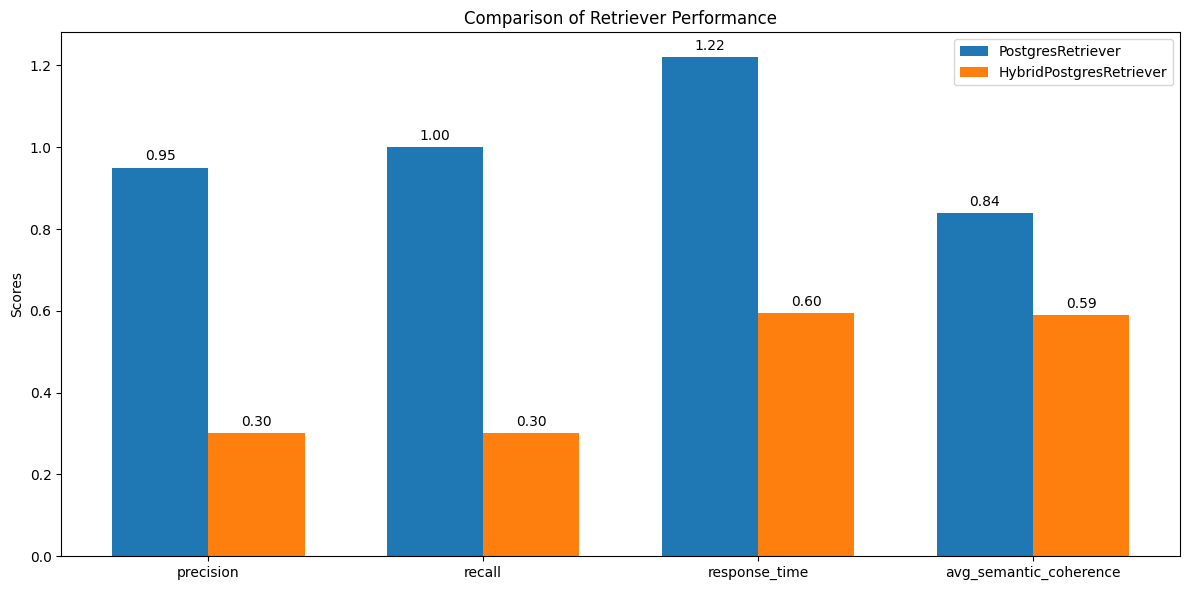


PostgresRetriever Results:
precision: 0.9500
recall: 1.0000
response_time: 1.2200
semantic_coherence:
  Number of queries with coherence scores: 10
  Average coherence score: 0.8381
  Min coherence score: 0.7592
  Max coherence score: 0.9000

HybridPostgresRetriever Results:
precision: 0.3000
recall: 0.3000
response_time: 0.5951
semantic_coherence:
  Number of queries with coherence scores: 1
  Average coherence score: 0.5897
  Min coherence score: 0.5897
  Max coherence score: 0.5897


In [99]:
# Test queries
# Test queries
test_queries = [
    "What are symptoms of depression?",
    "How to deal with anxiety?",
    "Is therapy effective for PTSD?",
    "What are common causes of insomnia?",
    "How does exercise affect mental health?",
    "What are signs of bipolar disorder?",
    "How to help someone with an eating disorder?",
    "What is cognitive behavioral therapy?",
    "How to manage stress at work?",
    "What are the effects of childhood trauma?"
]

def run_comparison_tests(retrievers, queries):
    results = {name: {} for name in retrievers.keys()}
    
    for name, retriever in retrievers.items():
        precision_sum, recall_sum = 0, 0
        response_times = []
        all_coherence_scores = []
        
        for query in queries:
            start_time = time()
            docs = retriever._get_relevant_documents(query)
            response_times.append(time() - start_time)
            
            relevant = sum(1 for doc in docs if any(word in doc.page_content.lower() for word in query.lower().split()))
            precision = relevant / len(docs) if docs else 0
            recall = 1 if relevant > 0 else 0
            precision_sum += precision
            recall_sum += recall
            
            doc_vectors = [np.array(doc.metadata.get('question_vector', [])) for doc in docs]
            doc_vectors = [v for v in doc_vectors if v.size > 0]  # Remove empty vectors
            
            if len(doc_vectors) > 1:
                similarities = cosine_similarity(doc_vectors)
                np.fill_diagonal(similarities, 0)  # Exclude self-similarities
                coherence_score = np.mean(similarities)
                all_coherence_scores.append(coherence_score)
        
        results[name]['precision'] = precision_sum / len(queries)
        results[name]['recall'] = recall_sum / len(queries)
        results[name]['response_time'] = np.mean(response_times)
        results[name]['semantic_coherence'] = all_coherence_scores
    
    return results

# Run the comparison
retrievers = {
    'PostgresRetriever': postgres_retriever,
    'HybridPostgresRetriever': hybrid_retriever
}
comparison_results = run_comparison_tests(retrievers, test_queries)

# Prepare data for visualization
metrics = ['precision', 'recall', 'response_time']
postgres_scores = [comparison_results['PostgresRetriever'][m] for m in metrics]
hybrid_scores = [comparison_results['HybridPostgresRetriever'][m] for m in metrics]

# Add average semantic coherence
postgres_coherence = np.mean(comparison_results['PostgresRetriever']['semantic_coherence']) if comparison_results['PostgresRetriever']['semantic_coherence'] else 0
hybrid_coherence = np.mean(comparison_results['HybridPostgresRetriever']['semantic_coherence']) if comparison_results['HybridPostgresRetriever']['semantic_coherence'] else 0
metrics.append('avg_semantic_coherence')
postgres_scores.append(postgres_coherence)
hybrid_scores.append(hybrid_coherence)

# Visualization
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, postgres_scores, width, label='PostgresRetriever')
rects2 = ax.bar(x + width/2, hybrid_scores, width, label='HybridPostgresRetriever')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Retriever Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

# Print detailed results
for name, metrics in comparison_results.items():
    print(f"\n{name} Results:")
    for metric, value in metrics.items():
        if metric == 'semantic_coherence':
            print(f"{metric}:")
            print(f"  Number of queries with coherence scores: {len(value)}")
            print(f"  Average coherence score: {np.mean(value) if value else 0:.4f}")
            print(f"  Min coherence score: {min(value) if value else 0:.4f}")
            print(f"  Max coherence score: {max(value) if value else 0:.4f}")
        else:
            print(f"{metric}: {value:.4f}")